In [7]:
import torch
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from PIL import Image, ImageFilter
import warnings
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from utils.ImageSet import ImageSet
from utils.utils_tumor import (
    load_models,
    get_pred_proba_multi,
    gen_image_from_coords,
    gen_multiscale_patches,
    compute_mean_predictions,
)

warnings.filterwarnings("ignore")

In [8]:
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

batch_size = config["model"]["batch_size"]
patch_size = config["patching"]["patch_size"]
colors = {
    0: config["visualization"]["colors"]["healthy"],
    1: config["visualization"]["colors"]["non_pej"],
    2: config["visualization"]["colors"]["pej"],
}
colors_TNT = {
    0: config["visualization"]["colors"]["healthy"],
    1: config["visualization"]["colors"]["pej"],
    2: config["visualization"]["colors"]["pej"],
}
classes = ["NT", "Non Pej", "Pej"]

vis_scale = config["patching"]["vis_scale"]
step = int(vis_scale * patch_size)

cmap = plt.get_cmap(config["visualization"]["color_map"])
normalizer = Normalize(0, 1)
im = cm.ScalarMappable(normalizer, cmap)

In [9]:
tumor_checkpoints = "../" + config["paths"]["pth_to_tumor_ckpts"]
patches_dir = "../" + config["paths"]["pth_to_patches"]
coords_checkpoints = "../" + config["paths"]["pth_to_coords"]
preds_wsis_results = "../" + config["paths"]["pth_to_preds_wsis"]

In [10]:
models = load_models(pth="../" + config["model"]["path_triple_resnets"])

loading TripleResnet34: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


read & gen multiscale patches: 100%|██████████| 2795/2795 [02:32<00:00, 18.32it/s]


model 1 

Prediction NT/NP/P: 100%|██████████| 88/88 [01:32<00:00,  1.05s/it]


model 2 

Prediction NT/NP/P: 100%|██████████| 88/88 [01:29<00:00,  1.02s/it]


model 3 

Prediction NT/NP/P: 100%|██████████| 88/88 [01:30<00:00,  1.03s/it]


model 4 

Prediction NT/NP/P: 100%|██████████| 88/88 [01:29<00:00,  1.01s/it]


model 5 

Prediction NT/NP/P: 100%|██████████| 88/88 [01:21<00:00,  1.08it/s]


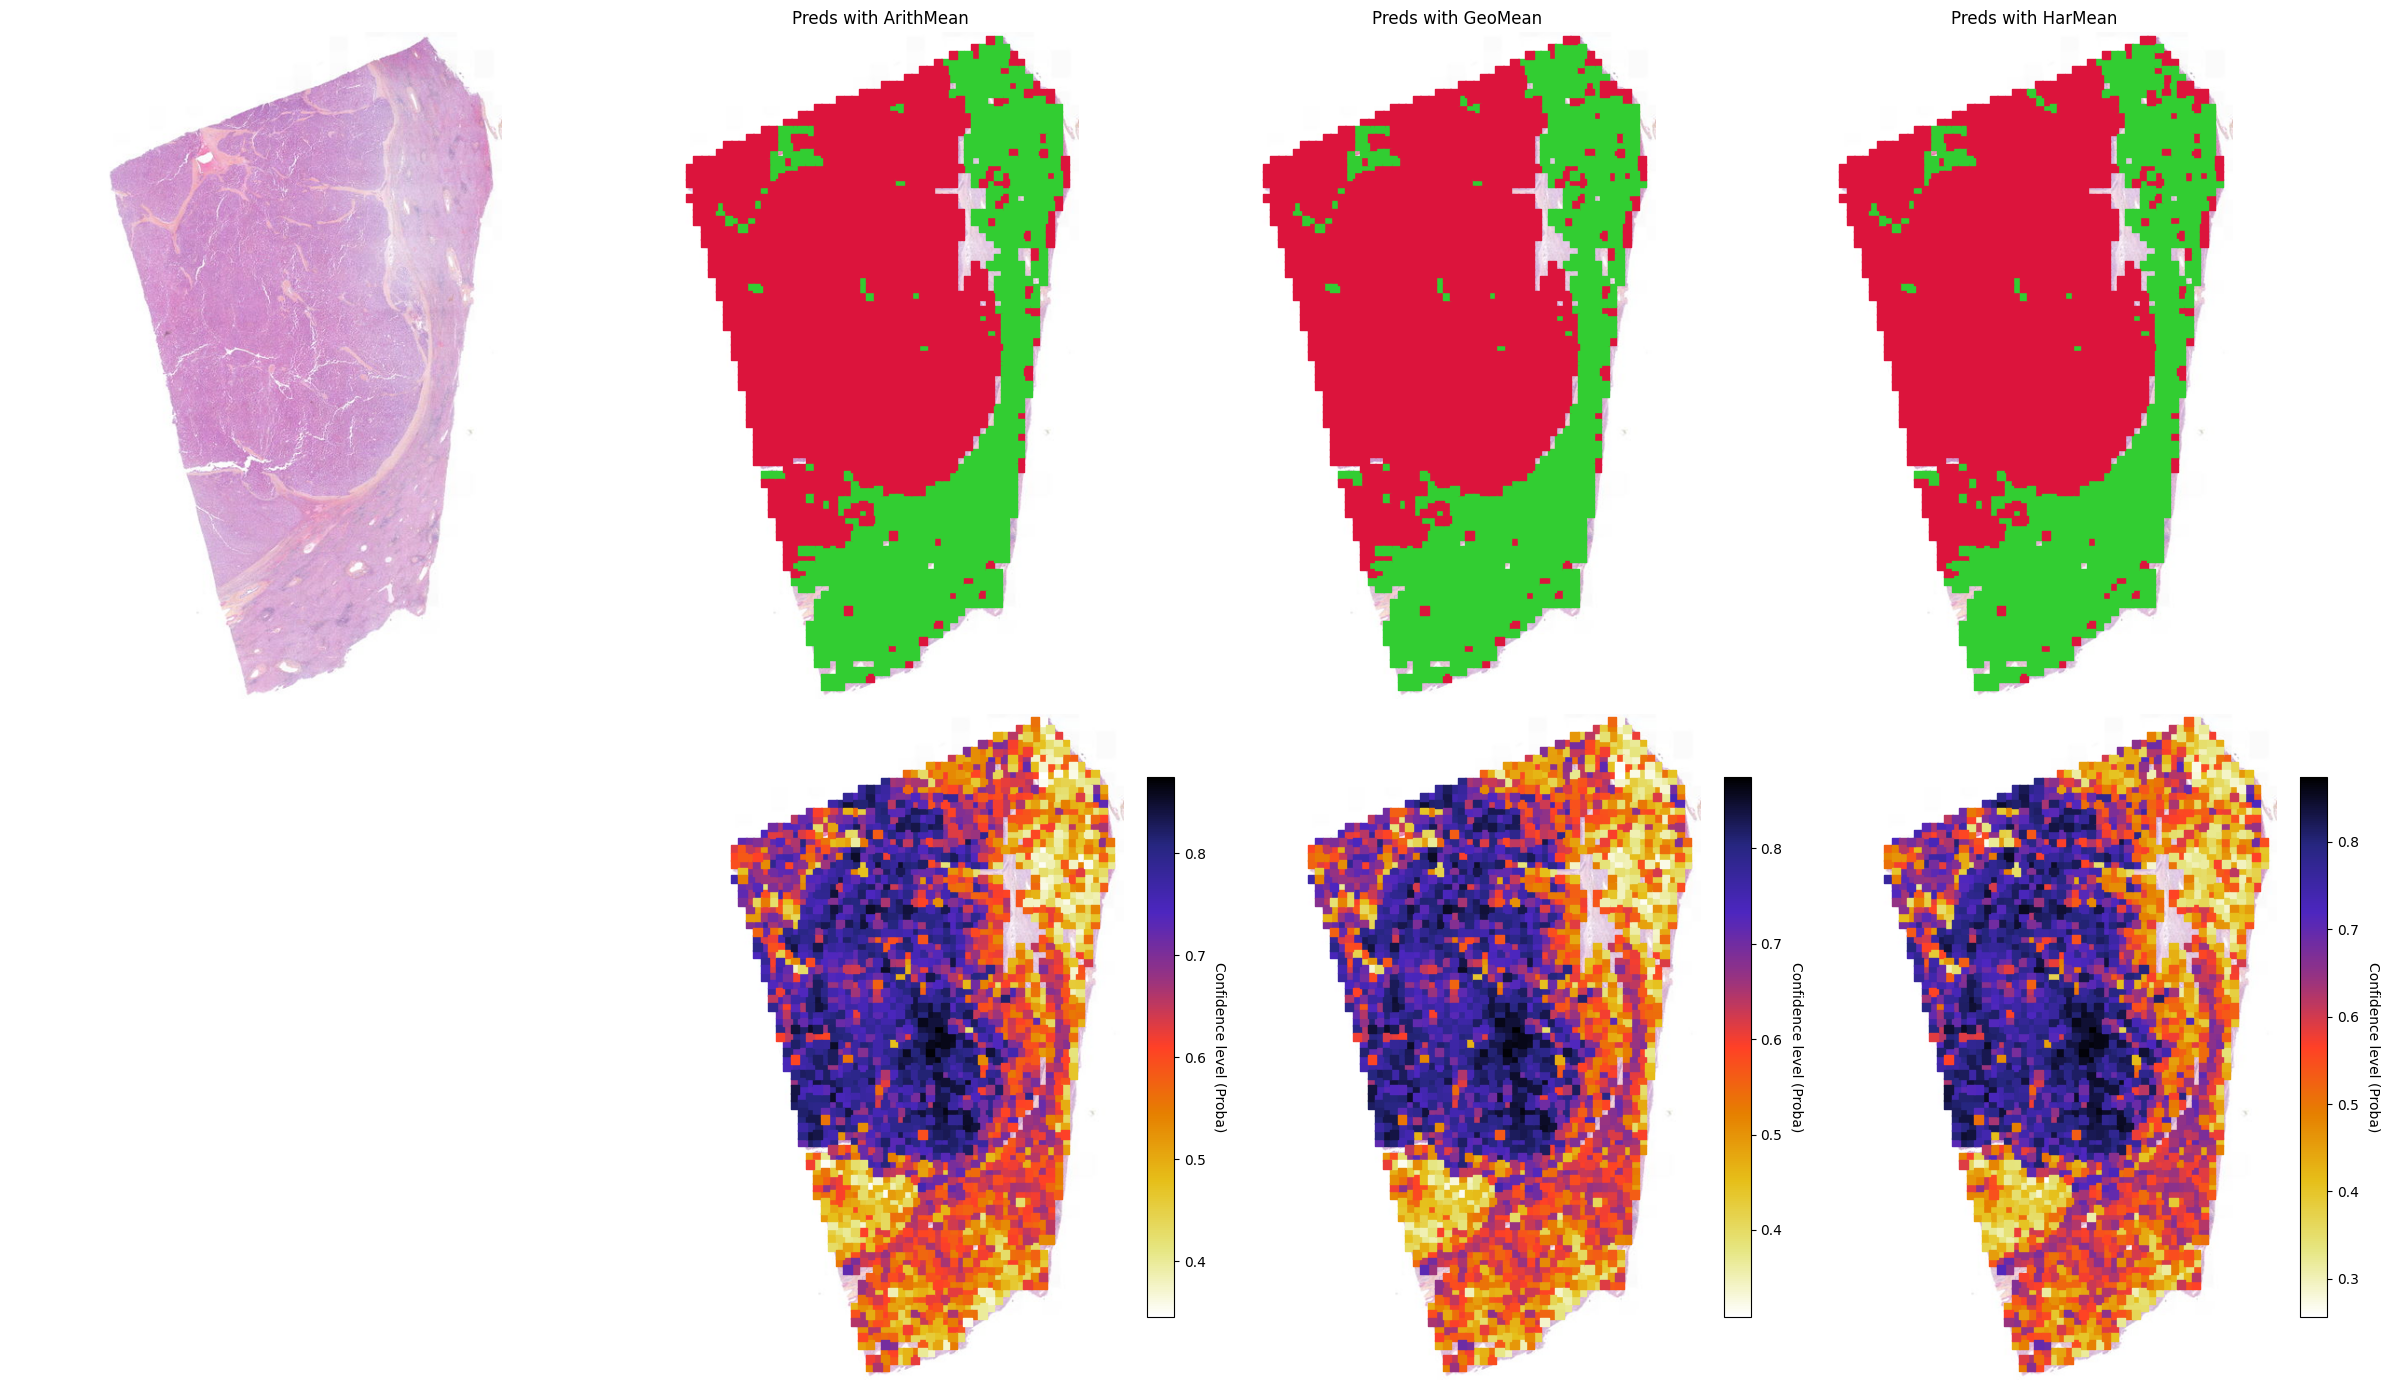

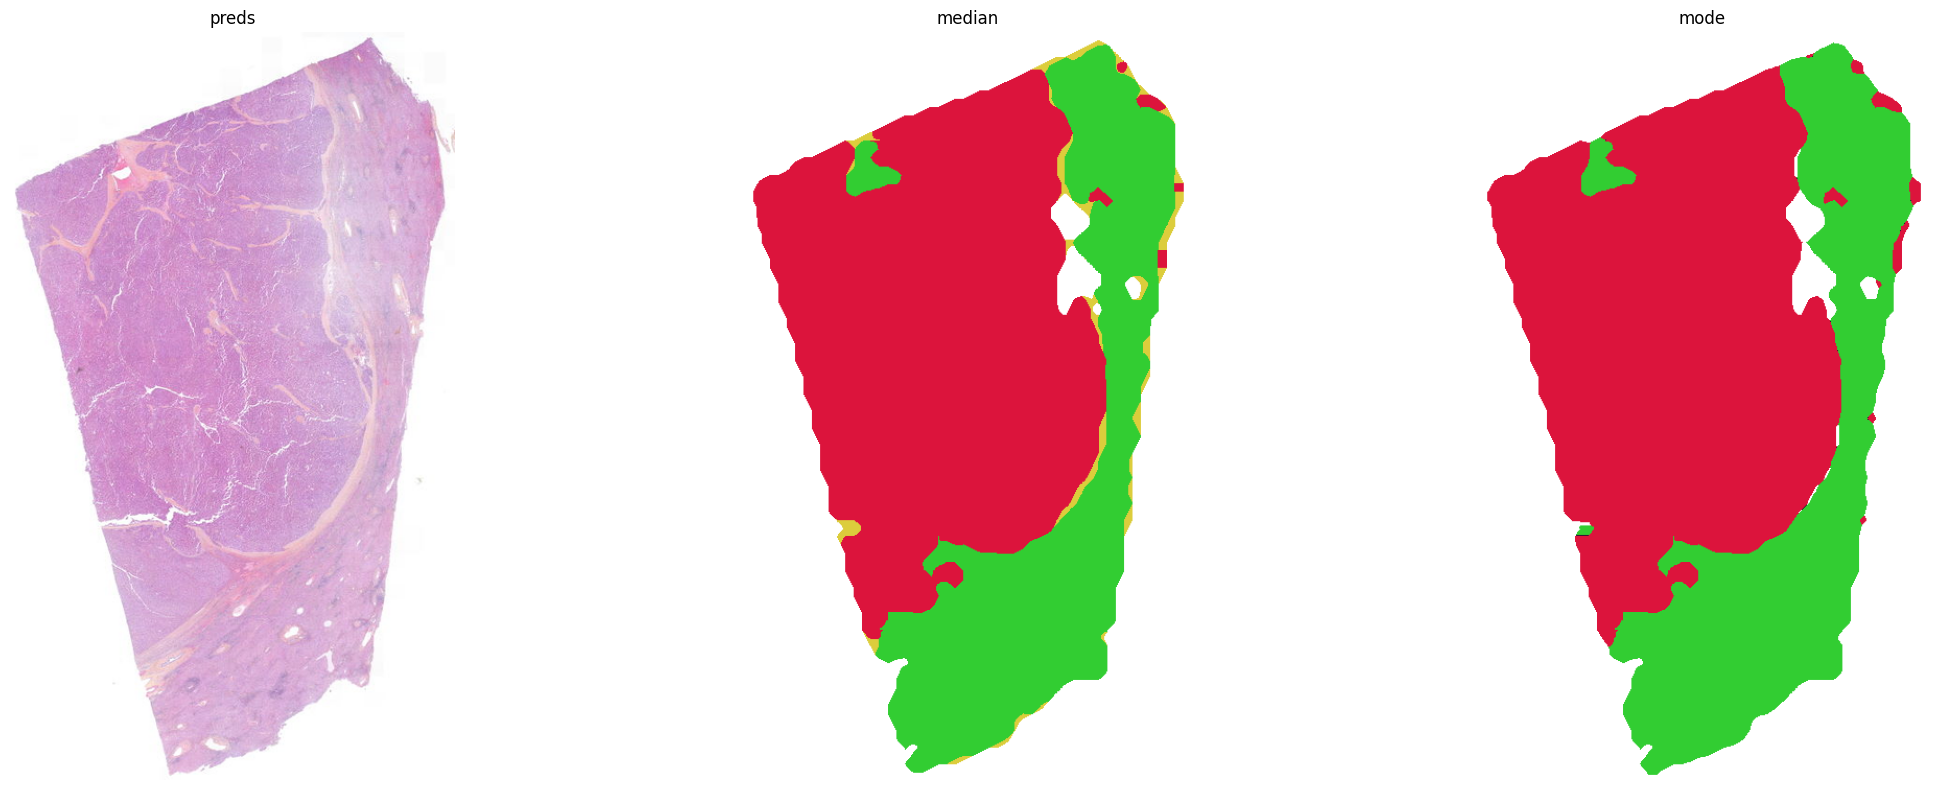

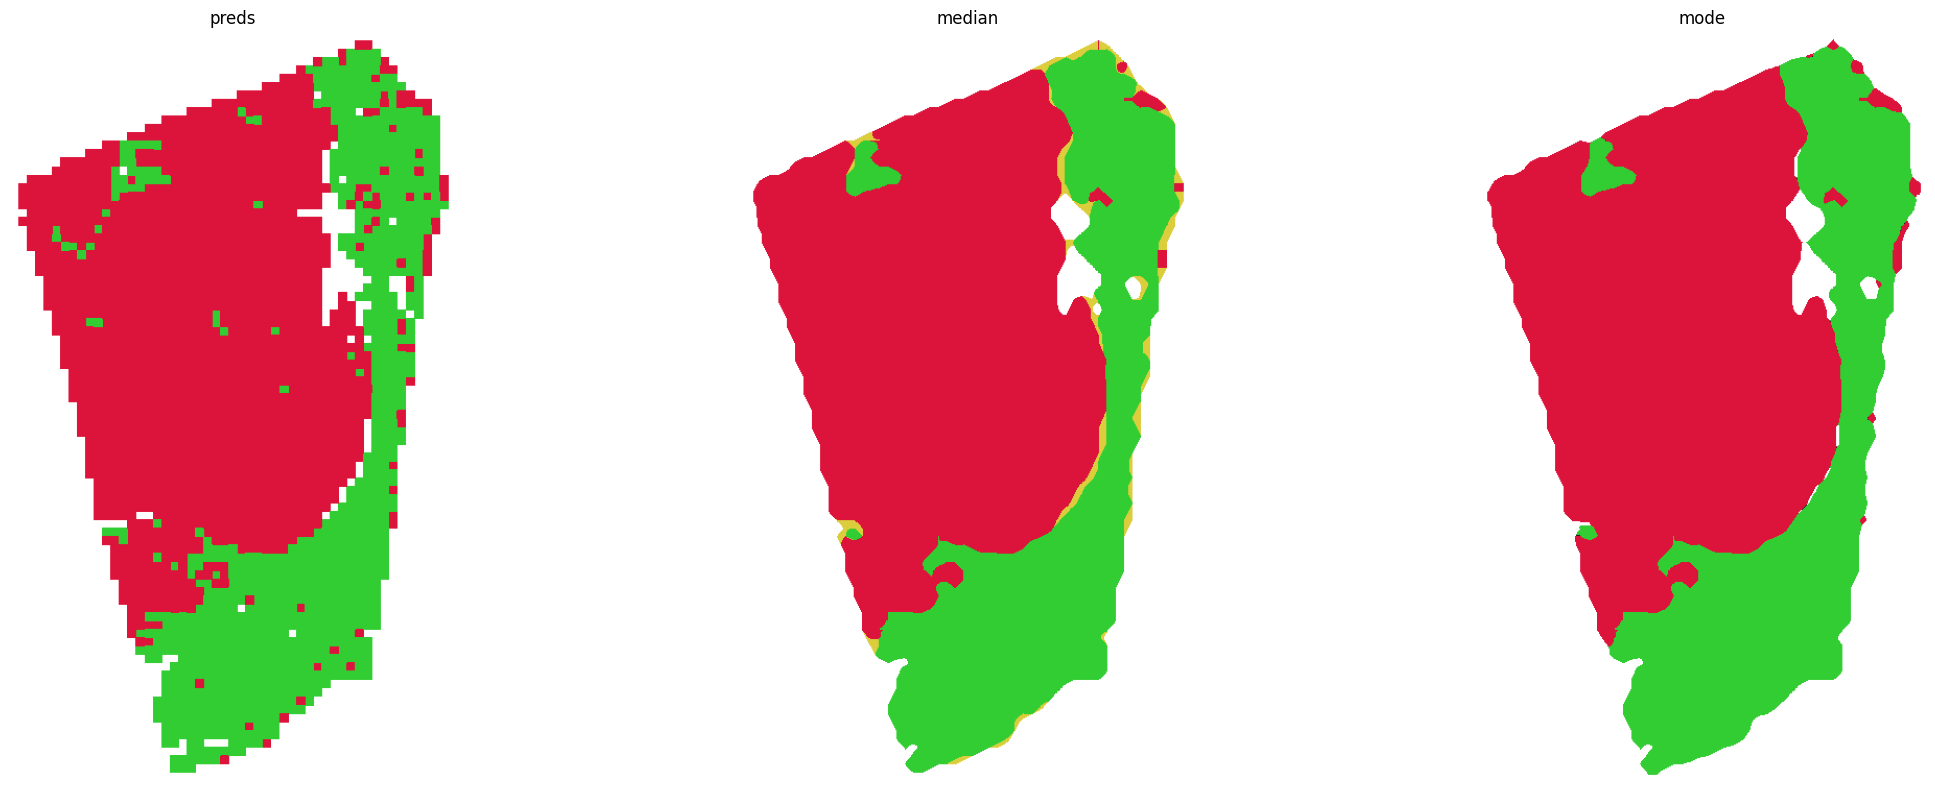

In [12]:
reference_pb = plt.imread("HES__5.jpeg")
plt.imshow(reference_pb)
plt.axis("off")
plt.show()

slides = os.listdir(patches_dir)
slides.sort()

for slide_name in ["63A"]:
    print(slide_name)
    if (
        0 < int(slide_name[:-1]) < 161
        or 212 < int(slide_name[:-1]) < 223
        or 252 < int(slide_name[:-1])
    ):
        print("patches are from Paul-Brousse ==> no color transfer needed")
        X, Y = gen_multiscale_patches(slide_name, patches_dir)
    else:
        print("patches are from Beaujon ==> color transfer is needed")
        X, Y = gen_multiscale_patches(
            slide_name, patches_dir, apply_clr_transfer=True, reference=reference_pb
        )

    Data = ImageSet(X, Y, tt.Compose([tt.ToTensor()]))
    loader = DataLoader(Data, batch_size=batch_size, shuffle=False)
    all_y_probas = []
    with torch.no_grad():
        for i, m in enumerate(models):
            print(f"model {i+1 }", end=" ")
            _, _, y_proba = get_pred_proba_multi(m, loader)
            all_y_probas.append(y_proba)

    y_arith_mean_proba, y_arith_preds = compute_mean_predictions(
        all_y_probas, "arithmetic"
    )
    y_geo_mean_proba, y_geo_preds = compute_mean_predictions(all_y_probas, "geometric")
    y_har_mean_proba, y_har_preds = compute_mean_predictions(all_y_probas, "harmonic")

    coords_x, coords_y = [], []
    for patch in os.listdir(f"{patches_dir}/{slide_name}"):
        _, _, x, _, y = patch[:-4].split("_")
        coords_x.append(int(x))
        coords_y.append(int(y))

    coords = torch.load(
        f"{coords_checkpoints}/{slide_name}_coords_checkpoint.pt", weights_only=False
    )
    scaled_slide = coords["scaled_slide"]
    [x_start, y_start, x_end, y_end] = coords["xy_start_end"]
    [real_x, real_y, real_w, real_h] = coords["xywh_real"]
    width, height = int(real_w * vis_scale), int(real_h * vis_scale)

    to_save = {
        "scaled_slide": scaled_slide,
        "coords_x": coords_x,
        "coords_y": coords_y,
        "har_mean_proba": y_har_mean_proba,
        "har_mean_preds": y_har_preds,
        "geo_mean_proba": y_geo_mean_proba,
        "geo_mean_preds": y_geo_preds,
        "arith_mean_proba": y_arith_mean_proba,
        "arith_mean_preds": y_arith_preds,
    }
    handle = f"{tumor_checkpoints}/{slide_name}_preds_probas_checkpoint.pt"
    torch.save(to_save, handle)

    coords_x = np.array(coords_x) * vis_scale - x_start
    coords_y = np.array(coords_y) * vis_scale - y_start
    pred_sets = [
        ("ArithMean", y_arith_preds, y_arith_mean_proba),
        ("GeoMean", y_geo_preds, y_geo_mean_proba),
        ("HarMean", y_har_preds, y_har_mean_proba),
    ]
    fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(24, 14))
    for j, (title, preds, probas) in enumerate(pred_sets, start=1):
        class_colors = [np.array(colors[int(p.item())]) / 255.0 for p in preds]
        prob_values = [p.max().item() for p in probas]
        ax[0, j].imshow(scaled_slide)
        ax[0, j].scatter(coords_x, coords_y, c=class_colors, marker="s")
        ax[0, j].set_title(f"Preds with {title}")
        ax[0, j].axis("off")
        ax[1, j].imshow(scaled_slide)
        sc = ax[1, j].scatter(coords_x, coords_y, c=prob_values, marker="s", cmap=cmap)
        ax[1, j].axis("off")
        cbar = fig.colorbar(sc, ax=ax[1, j], fraction=0.046, pad=0.04)
        cbar.set_label("Confidence level (Proba)", rotation=270, labelpad=15)
    ax[0, 0].imshow(scaled_slide)
    ax[0, 0].axis("off")
    ax[1, 0].axis("off")
    plt.tight_layout()
    plt.savefig(f"{preds_wsis_results}/{slide_name}_preds_NT_NP_P.png")
    plt.show()

    image_arith = gen_image_from_coords(coords_x, coords_y, y_arith_preds, step, colors)
    median_filtered = Image.fromarray(image_arith).filter(
        ImageFilter.MedianFilter(size=2 * step + 1)
    )
    mode_filtered = Image.fromarray(image_arith).filter(
        ImageFilter.ModeFilter(size=2 * step + 1)
    )

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    axes[0].imshow(scaled_slide)
    axes[0].set_title("preds")
    axes[0].axis("off")
    axes[1].imshow(median_filtered)
    axes[1].set_title("median")
    axes[1].axis("off")
    axes[2].imshow(mode_filtered)
    axes[2].set_title("mode")
    axes[2].axis("off")
    plt.tight_layout()
    plt.savefig(f"{preds_wsis_results}/{slide_name}_preds_NT_NP_P_smoothed_Arith.png")
    plt.show()

    image_geo = gen_image_from_coords(coords_x, coords_y, y_geo_preds, step, colors_TNT)
    image_har = gen_image_from_coords(coords_x, coords_y, y_har_preds, step, colors_TNT)
    median_filtered = Image.fromarray(image_geo).filter(
        ImageFilter.MedianFilter(size=2 * step + 1)
    )  #
    mode_filtered = Image.fromarray(image_geo).filter(
        ImageFilter.ModeFilter(size=2 * step + 1)
    )

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    axes[0].imshow(image_geo)
    axes[0].set_title("preds")
    axes[0].axis("off")
    axes[1].imshow(median_filtered)
    axes[1].set_title("median")
    axes[1].axis("off")
    axes[2].imshow(mode_filtered)
    axes[2].set_title("mode")
    axes[2].axis("off")
    plt.tight_layout()
    plt.savefig(f"{preds_wsis_results}/{slide_name}_preds_NT_T_smoothed_Geo.png")
    plt.show()